ReadMe
---



---

Sahabat Belajar (SABA) or study companion is our capstone project for Bangkit 2021 For more information please visit or git hub [SABA](https://github.com/Bagoes-Heikhal/SABA)

In [1]:
# Chatbot with Deep NLP
#Importing the libraries
import numpy as np
import tensorflow
import re
import time 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional
from google.colab import drive

In [2]:
print(tensorflow.__version__)

2.5.0


In [3]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Preprocess**
---


---



In [4]:
############## Import Dataset #############
############## Untuk Drive ################## 
# questions = open ('/content/drive/MyDrive/Colab Notebooks/SABA/data/QuestionFisika.txt', encoding = 'utf-8', errors = 'ignore').read().split('\n')
# answers = open ('/content/drive/MyDrive/Colab Notebooks/SABA/data/AnswerFisika.txt', encoding = 'utf-8', errors = 'ignore').read().split('\n')
questions = open ('/content/drive/MyDrive/Colab Notebooks/SABA/data/Questions.txt', encoding = 'utf-8', errors = 'ignore').read().split('\n')
answers = open ('/content/drive/MyDrive/Colab Notebooks/SABA/data/Answers.txt', encoding = 'utf-8', errors = 'ignore').read().split('\n')

In [5]:
####### Cleaning text dari tanda baca dan agar seragam #######
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'" - "+', "", text)
    text = re.sub(r'" +"', " ", text)
    text = re.sub(r'"^ "', "", text)
    text = re.sub(r'[-()\"#/@;:<>{}`+=~|.!?,]', "", text)
    text = re.sub(r'[\-\-]', "", text)
    text = re.sub(r'\.\.\.', "", text)
    text = re.sub(r'^- ', "", text)
    return text

In [6]:
############### Petanyaan dan Jawaban clean ###############
clean_questions = []
for question in questions:
    clean_questions.append(clean_text(question))
    
clean_answers = []
for answer in answers:
    clean_answers.append(clean_text(answer))

In [7]:
############### Untuk Tokenizer dan input embedding layers ############### 
word2count = {}
for question in clean_questions:
    for word in question.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

for answer in clean_answers:
    for word in answer.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

print(len(word2count))

3282


In [8]:
############ Membatasi batas minimum dictionary yang digunakan ##############
threshold = 5

vocab = {}
word_num = 0
for word, count in word2count.items():
    if count >= threshold:
        vocab[word] = word_num
        word_num += 1

print(len(vocab))

2653


In [9]:
##### Memberikan Token Start of Sentence (SOS),
##### End of Sentence (EOS)
##### PAD untuk padding dan OUT untuk kata yang tidak ada di vocab

for i in range(len(clean_answers)):
    clean_answers[i] = '<SOS> ' + clean_answers[i] + ' <EOS>'

tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)
for token in tokens:
    vocab[token] = x
    x += 1

    
print(clean_questions[0])
print(clean_answers[0])

apakah kamu terluka
<SOS> aku tidak punya tubuh <EOS>


In [10]:
###### inverse untuk decode ######
inv_vocab = {w:v for v, w in vocab.items()}

In [11]:
###### Encoder Input ######
encoder_inp = []
for line in clean_questions:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

In [12]:
###### Decoder Input ######
decoder_inp = []
for line in clean_answers:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)

**Encode Model**
---

---





In [13]:
############ Hyperparameters ##################
max_input_len = 15
lstm_layers = 400
VOCAB_SIZE = len(vocab)

In [14]:
#### Padding agar panjang encoder dan decoder sama ketika di training ####
encoder_inp = pad_sequences(encoder_inp, maxlen = max_input_len, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, maxlen = max_input_len, padding='post', truncating='post')

In [15]:
#### Untuk output target learning ####

decoder_final_output = []
for i in decoder_inp:
    decoder_final_output.append(i[1:])

decoder_final_output = pad_sequences(decoder_final_output, maxlen = max_input_len, padding='post', truncating='post')
decoder_final_output = to_categorical(decoder_final_output, len(vocab))
print(decoder_final_output.shape)

(48371, 15, 2657)


In [16]:
##### Embedding layer utama ####
embedding = Embedding(VOCAB_SIZE + 1,
                      output_dim = 50, 
                      input_length = max_input_len,
                      trainable = True,
                      mask_zero = True 
                      )

In [17]:
########### Encode  #############

########### Encoder #############
e_input = Input(shape=(max_input_len, ))
e_embeded = embedding(e_input)
e_lstm = LSTM(lstm_layers, return_sequences=True, return_state=True)
e_op, h_state, c_state = e_lstm(e_embeded)
e_states = [h_state, c_state]

########### Decoder #############
d_input = Input(shape=(max_input_len, ))
d_embeded = embedding(d_input)
d_lstm = LSTM(lstm_layers, return_sequences=True, return_state=True)
d_output, _, _ = d_lstm(d_embeded, initial_state = e_states)
d_dense = Dense(VOCAB_SIZE, activation='softmax')
d_outputs = d_dense(d_output)

model = Model([e_input, d_input], d_outputs)

**TRAINING**
---

---






In [18]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['acc'])

# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
############################ Untuk Memulai Training ############################

history = model.fit([encoder_inp, decoder_inp], decoder_final_output, epochs=25, validation_split=0.2)

Epoch 1/25
1210/1210 [==============================] - 85s 64ms/step - loss: 1.3520 - acc: 0.4637 - val_loss: 2.7879 - val_acc: 0.3491
Epoch 2/25
1210/1210 [==============================] - 75s 62ms/step - loss: 0.4651 - acc: 0.7799 - val_loss: 2.9702 - val_acc: 0.3743
Epoch 3/25
1210/1210 [==============================] - 74s 62ms/step - loss: 0.2881 - acc: 0.8383 - val_loss: 3.1515 - val_acc: 0.3921
Epoch 4/25
1210/1210 [==============================] - 74s 61ms/step - loss: 0.2137 - acc: 0.8615 - val_loss: 3.2608 - val_acc: 0.3953
Epoch 5/25
1210/1210 [==============================] - 74s 61ms/step - loss: 0.1762 - acc: 0.8730 - val_loss: 3.3678 - val_acc: 0.3956
Epoch 6/25
1210/1210 [==============================] - 74s 61ms/step - loss: 0.1561 - acc: 0.8795 - val_loss: 3.4540 - val_acc: 0.3913
Epoch 7/25
1210/1210 [==============================] - 74s 61ms/step - loss: 0.1437 - acc: 0.8837 - val_loss: 3.5760 - val_acc: 0.3966
Epoch 8/25
1210/1210 [==========================

**Inference**
---



---



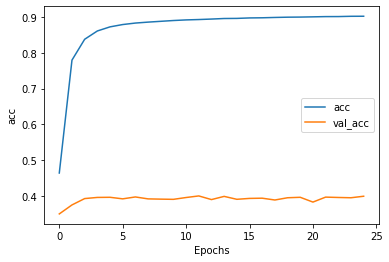

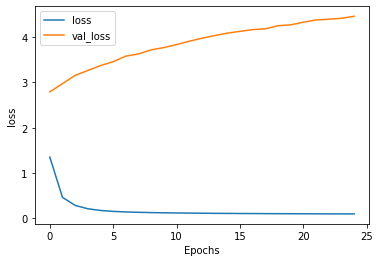

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [21]:
######### Decode  #############

######### Encoder #############
enc_model = Model([e_input], e_states)

######### Decoder #############
d_input_h = Input(shape=(lstm_layers,))
d_input_c = Input(shape=(lstm_layers,))
d_states_inputs = [d_input_h, d_input_c]
d_outputs, d_state_h, d_state_c = d_lstm(d_embeded, initial_state = d_states_inputs)
d_states = [d_state_h, d_state_c]
dec_model = Model([d_input] + d_states_inputs, [d_outputs] + d_states)

In [22]:
############# Untuk Meload Model & weigth ##################
# enc_model.load_weights('./enc_model_fisika.h5')
# dec_model.load_weights('./dec_model_fisika.h5')
# model.load_weights('./main_model.h5')

In [23]:
############ plot Model ############

# from keras.utils.vis_utils import plot_model
# plot_model(enc_model, show_shapes=True, show_layer_names=True)
# plot_model(dec_model, show_shapes=True, show_layer_names=True)
# enc_model.summary()
# dec_model.summary()

In [24]:
########## Untuk mengholah data input sebelum di inference ##########

def input_sentence(text):
    user_ = clean_text(text)
    user = [user_]

    inp_sentence = []
    for sentence in user:
        lst = []
        for y in sentence.split():
            try:
                lst.append(vocab[y])
            except:
                lst.append(vocab['<OUT>'])
        inp_sentence.append(lst)
    
    inputs_sentence = pad_sequences(inp_sentence, max_input_len, padding='post')
    states_value = enc_model.predict(inputs_sentence)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = vocab['<SOS>']

    return target_seq, states_value

In [31]:
############# BOT SABA #################
user_ = ""
while user_ != 'quit':
    user_  = input("you : ")
    target_seq, states_value = input_sentence(user_)

    stop_condition = False
    decoded = ''

    while not stop_condition :
        output_tokens , h, c= dec_model.predict([target_seq] + states_value )
        input_tokens = d_dense(output_tokens)
        word_index = np.argmax(input_tokens[0, -1, :])

        ### Invers dari angka ke word index dalam vocab ###
        word = inv_vocab[word_index] + ' '
        if word != '<EOS> ':
            decoded += word  
        if word == '<EOS> ' or len(decoded.split()) > 13:
            stop_condition = True 

        target_seq = np.zeros((1 , 1))  
        target_seq[0 , 0] = word_index
        states_value = [h, c]

    print("saba : ", decoded)
    print("==============================================")  

you : quit
saba :  itu bukan salah satu kekuatanku 


**Saving Model & Weights**
---

---

In [26]:
# enc_model.save_weights('./enc_model_fisika.h5')
# dec_model.save_weights('./dec_model_fisika.h5')
# model.save_weights('./main_model.h5')